# **Topic Modeling with Quantized LLMs**
*Create easily interpretable topics with BERTopic and LLMs*
<br>

<img src="https://pbs.twimg.com/media/GDA2JQoX0AElWoq?format=jpg&name=large">


---
        
💡 **NOTE**: We will want to use a GPU to run both 7B LLMs as well as BERTopic for this use case. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

We will start by installing a number of packages that we are going to use throughout this example:

In [1]:
"""
#%%capture
# BERTopic + llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --no-cache-dir
!pip install bertopic datasets

# DataMapPlot
#!git clone https://github.com/TutteInstitute/datamapplot.git
#!pip install datamapplot/.
!pip install datamapplot
"""

'\n#%%capture\n# BERTopic + llama-cpp-python\n!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --no-cache-dir\n!pip install bertopic datasets\n\n# DataMapPlot\n#!git clone https://github.com/TutteInstitute/datamapplot.git\n#!pip install datamapplot/.\n!pip install datamapplot\n'

In [2]:
"""
# GPU-accelerated HDBSCAN + UMAP
!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64
"""

'\n# GPU-accelerated HDBSCAN + UMAP\n!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com\n!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com\n!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com\n!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64\n'

# 📄 **Data**

We are going to apply topic modeling on a number of ArXiv abstracts. They are a great source for topic modeling since they contain a wide variety of topics and are generally well-written.

In [9]:
from datasets import load_dataset

# ArXiv ML Documents
docs = load_dataset("CShorten/ML-ArXiv-Papers")["train"]["abstract"]

In [4]:
len(docs)

117592

# 🦙 **Quantized LLM**

To use a quantized LLMs, we make use of the `GGUF` format together with `llama-cpp-python`. When you access any of [TheBloke's quantized models](https://huggingface.co/TheBloke), you can click on files and find specific quantized formats. We are going with a 4-bit quantized model:

In [5]:
#!wget https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
# !wget https://huggingface.co/TheBloke/dolphin-2.7-mixtral-8x7b-GGUF/resolve/main/dolphin-2.7-mixtral-8x7b.Q3_K_M.gguf

Next, we load the model using `llama-cpp-python`:

In [1]:
from llama_cpp import Llama
#model_path="/home/maitre/Documents/Models/mistral-7b-instruct-v0.1.Q5_K_M.gguf"
model_path="/home/maitre/Documents/Development/text-generation-webui/models/mixtral-8x7b-instruct-v0.1.Q3_K_M.gguf"
# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=25, n_ctx=8192, stop=["Q:", "\n"])

ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 3090, compute capability 8.6, VMM: yes
llama_model_loader: loaded meta data with 26 key-value pairs and 995 tensors from /home/maitre/Documents/Development/text-generation-webui/models/mixtral-8x7b-instruct-v0.1.Q3_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mixtral-8x7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_co

We pass the LLM to BERTopic with a custom prompt. Let's add `KeyBERTInspired` representations to compare the LLM representations with:

In [2]:
from bertopic.representation import KeyBERTInspired, LlamaCPP

prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
}

# 🗨️ **BERTopic**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [3]:
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
import pickle
# from umap import UMAP
# from hdbscan import HDBSCAN


In [ ]:

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

In [9]:

with open('embeddings_abstracts_mixtral', 'wb') as f:
    pickle.dump(embeddings, f)

In [5]:
with open('embeddings_abstracts_mixtral', 'rb') as f:
    embeddings = pickle.load(f)

In [7]:
# Define sub-models
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=400, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [10]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2024-02-25 23:47:43,501 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


2024-02-25 23:47:45,577 - BERTopic - Dimensionality - Completed ✓
2024-02-25 23:47:45,579 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-25 23:47:51,192 - BERTopic - Cluster - Completed ✓
2024-02-25 23:47:51,206 - BERTopic - Representation - Extracting topics from clusters using representation models.
  0%|          | 0/33 [00:00<?, ?it/s]
llama_print_timings:        load time =    2702.27 ms
llama_print_timings:      sample time =       2.18 ms /     8 runs   (    0.27 ms per token,  3663.00 tokens per second)
llama_print_timings: prompt eval time =    7700.61 ms /  1373 tokens (    5.61 ms per token,   178.30 tokens per second)
llama_print_timings:        eval time =     494.12 ms /     7 runs   (   70.59 ms per token,    14.17 tokens per second)
llama_print_timings:       total time =    8217.29 ms /  1380 tokens
  3%|▎         | 1/33 [00:08<04:23,  8.22s/it]Llama.generate: prefix-match hit

llama_print_timings:        load time =    2702.27 ms
llama_print_ti

Now that we are done training our model, let's see what topics were generated:

In [11]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,60106,-1_the_of_and_to,"[the, of, and, to, in, we, is, for, that, on]","[models, model, datasets, algorithms, optimiza...","[Online Learning and Image Classification, , ,...",[ Can we automatically group images into sema...
1,0,6974,0_policy_learning_reinforcement_the,"[policy, learning, reinforcement, the, to, in,...","[dynamics, learning, model, reinforcement, tra...","[Reinforcement Learning Techniques, , , , , , ...",[ Model-free reinforcement learning (RL) meth...
2,1,6469,1_the_and_of_to,"[the, and, of, to, in, for, data, is, we, with]","[convolutional, mri, neural, brain, prediction...","[Deep Learning for Clinical Data Analysis, , ,...",[ Brain tumor is one of the leading causes of...
3,2,5907,2_language_the_and_of,"[language, the, and, of, to, in, we, text, on,...","[nlp, embeddings, language, corpus, semantic, ...","['Language Model Analysis', , , , , , , , , ]","[ Transfer learning, where a model is first p..."
4,3,3858,3_graph_the_of_node,"[graph, the, of, node, clustering, graphs, and...","[embeddings, embedding, networks, graphs, grap...","[""Graph Representation Learning"", , , , , , , ...",[ Graph clustering is a fundamental task whic...
5,4,3168,4_the_to_and_of,"[the, to, and, of, we, generative, image, in, ...","[gans, adversarial, generative, gan, models, m...","[Generative Image GANs, , , , , , , , , ]",[ We present a novel method and analysis to t...
6,5,2830,5_privacy_federated_fl_data,"[privacy, federated, fl, data, the, learning, ...","[federated, distributed, datasets, models, mod...","[Federated Learning Privacy, , , , , , , , , ]",[Privacy regulations and the physical distribu...
7,6,2786,6_speech_audio_the_speaker,"[speech, audio, the, speaker, to, of, and, in,...","[speech, voice, language, neural, trained, aud...","[Speech Processing Techniques, , , , , , , , , ]",[ Both acoustic and visual information influe...
8,7,2401,7_adversarial_attacks_robustness_attack,"[adversarial, attacks, robustness, attack, the...","[adversarial, adversarially, dnns, attacks, dn...","[Adversarial Attack Robustness, , , , , , , , , ]",[ Many existing deep learning models are vuln...
9,8,2281,8_the_of_and_to,"[the, of, and, to, in, for, is, data, neural, ...","[modeling, models, dynamics, model, pdes, simu...","[Deep Learning for PDEs, , , , , , , , , ]",[ Many scientific phenomena are modeled by Pa...


# 📊 Visualization with DataMapPlot

In [12]:
import PIL
import numpy as np
import requests

# Prepare logo
bertopic_logo_response = requests.get(
    "https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png",
    stream=True,
    headers={'User-Agent': 'My User Agent 1.0'}
)
bertopic_logo = np.asarray(PIL.Image.open(bertopic_logo_response.raw))

We can use the labels created by the LLM and assign them to topics that we have created:

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `openhermes-2.5-mistral-7b`'}>)

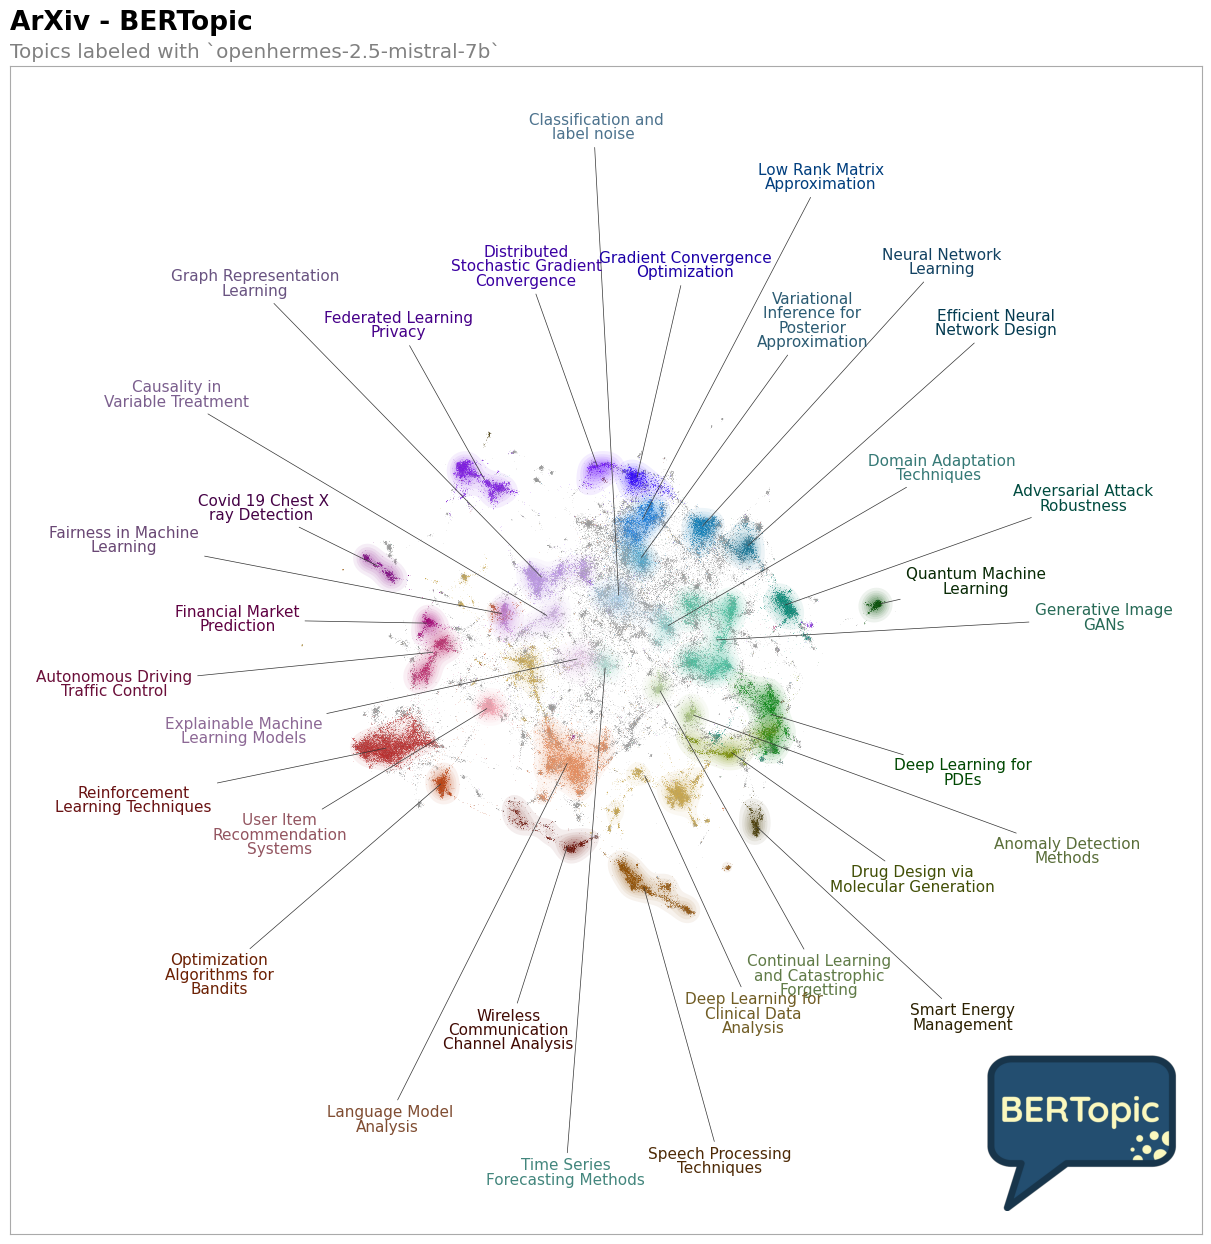

In [13]:
import datamapplot
import re

# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=11,
    title="ArXiv - BERTopic",
    sub_title="Topics labeled with `openhermes-2.5-mistral-7b`",
    label_wrap_width=20,
    use_medoids=True,
    logo=bertopic_logo,
    logo_width=0.16
)